# SQuat demo
Reproducing Figure 2 in the paper.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import pandas as pd
import seaborn as sns
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")


In [4]:
def vanilla_quant(k_full: torch.Tensor, b: int = 2, group_size: int = 32):
    seq_len, hidden_dim = k_full.shape
    num_groups = seq_len // group_size
    
    # Ensure b-bit representation
    levels = 2 ** b - 1
    
    # Initialize the output tensor
    k_dequantized = torch.zeros_like(k_full)
    
    for start in range(0, seq_len, group_size):
        end = min(start + group_size, seq_len)
        group = k_full[start:end]  # Extract the group
        
        # Compute min (m) and max (M) for each feature in hidden dimension
        m = group.min(dim=0).values
        M = group.max(dim=0).values
        
        # Compute scaling factor Δ
        delta = (M - m) / levels
        
        # Avoid division by zero
        delta[delta == 0] = 1e-8
        
        # Quantize
        quantized = torch.round((group - m) / delta)
        
        # Dequantize
        dequantized = quantized * delta + m
        
        # Store the dequantized values
        k_dequantized[start:end] = dequantized
    
    return k_dequantized

In [5]:
def generate_At_inv(T, g, d, my_Qhat, lamb = 1, tol = 1e-7):
    """
    Generate a list of T matrices where the t-th matrix has dimension (t*g, t*g).

    Parameters:
    - T (int): Number of matrices
    - g (int): Factor for matrix dimension scaling
    - d (int): Dimension of the identity matrix for A_T
    - lamb (float): Scaling factor for the final term
    - my_Qhat (torch.Tensor): A matrix of size (d, d)

    Returns:
    - List[torch.Tensor]: List of T matrices
    """
    matrices = [None] * T
    
    # Initialize A_T
    A_T = torch.eye(d) + lamb * torch.matmul(my_Qhat.T, my_Qhat)
    matrices[T - 1] = A_T

    # Recursive computation of A_{t} from A_{t+1}
    for t in range(T - 1, 0, -1):
        current_dim = t * g
        
        # Extract M_{t+1}, N_{t+1}, and O_{t+1}
        M_t1 = A_T[:current_dim, :current_dim]  # Top-left square matrix
        N_t1 = A_T[current_dim:current_dim + g, :current_dim]  # Bottom-left matrix
        O_t1 = A_T[current_dim:current_dim + g, current_dim:current_dim + g]  # Bottom-right square matrix
        
        # Compute A_t
        O_t1_inv = torch.inverse(O_t1 + tol*torch.eye(g))
        A_t = M_t1 - torch.matmul(N_t1.T, torch.matmul(O_t1_inv, N_t1))
        matrices[t - 1] = A_t
        
        # Update A_T for the next iteration
        A_T = A_t

    return matrices

In [6]:
def new_quant(k_t: torch.Tensor, Ainv_t, P_inv, g, b: int = 2, group_size: int = 32):
    seq_len, hidden_dim = k_t.shape
    num_groups = seq_len // group_size
    
    # d needs to be divisible by g
    T = int(hidden_dim/g)

    # Ensure b-bit representation
    levels = 2 ** b - 1
    
    k1_0 = k_t.clone()

    # Initialize the output tensor
    k1_0_dequantized = torch.zeros_like(k1_0)

    
    for start in range(0, seq_len, group_size):
        
        end = min(start + group_size, seq_len)
        group = k1_0[start:end]  # Extract the group
        
        
        for i in range(T):
        
            # Compute min (m) and max (M) for each feature in hidden dimension
            m = group.min(dim=0).values[i*g:(i+1)*g]
            M = group.max(dim=0).values[i*g:(i+1)*g]

            # Compute scaling factor Δ
            delta = (M - m) / levels

            # Avoid division by zero
            delta[delta == 0] = 1e-8
        
            # Quantize
            quantized = torch.round((group[:,i*g:(i+1)*g] - m) / delta)
            dequantized = quantized * delta + m
            k1_0_dequantized[start:end,i*g:(i+1)*g] = dequantized

            if i < T-1:
                d_vec = (dequantized - group[:,i*g:(i+1)*g])
                H_t = Ainv_t[i]
                H_t = H_t[:, -g:]
                B_t = P_inv[(i+1)*g:, :(i+1)*g] #?

                update = d_vec @ H_t.transpose(0,1) @ B_t.transpose(0,1)

                group[:, (i+1)*g:] = group[:, (i+1)*g:] + update
            
    
    return k1_0_dequantized

In [7]:
def attention_gap(q, k, k_quant, mask, softmax = False):

    # Compute attention scores (scaled dot-product attention)
    q_seq_len, hidden_dim = q.shape  # Ensure correct dimensions
    k_seq_len, _ = k.shape
    #
    if softmax:
        attention_scores = torch.matmul(q, k.T) / (hidden_dim ** 0.5)
        attention_scores_quant = torch.matmul(q, k_quant.T) / (hidden_dim ** 0.5)
    else:
        attention_scores = torch.matmul(q, k.T)
        attention_scores_quant = torch.matmul(q, k_quant.T) 
    
    
    attention_scores = attention_scores.masked_fill(mask.bool(), float('-inf'))
    attention_scores_quant = attention_scores_quant.masked_fill(mask.bool(), float('-inf'))

    if softmax:
        # Apply softmax to normalize attention scores
        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)
        attention_probs_quant = torch.nn.functional.softmax(attention_scores_quant, dim=-1)
    else:
        attention_probs = attention_scores
        attention_probs_quant = attention_scores_quant
    
    # Convert to NumPy for visualization
    attention_probs_np = attention_probs.detach().numpy()
    attention_probs_np_quant = attention_probs_quant.detach().numpy()

    attention_probs_np = np.where(attention_probs_np == -np.inf, np.nan, attention_probs_np)
    attention_probs_np_quant = np.where(attention_probs_np_quant == -np.inf, np.nan, attention_probs_np_quant)
    score_diff = np.abs(attention_probs_np_quant - attention_probs_np)

    sum_error = np.nansum(score_diff)

    return score_diff, sum_error


def quant_error(k, k_quant):
    gap = k - k_quant
    gap_norms = torch.norm(gap, dim=1)
    mean_gap = torch.mean(gap_norms).item()

    return mean_gap

In [8]:
import matplotlib.colors as colors
import matplotlib.ticker as ticker
plt.style.use("dark_background")  # Makes the entire background black
sns.set_style("dark")  # Keeps the Seaborn styling
# # This dictionary defines the colormap
# cdict = {'red':  ((0.0, 0.0, 0.0),   # no red at 0
#                   (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
#                   (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

#         'green': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
#                   (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
#                   (1.0, 0.0, 0.0)),  # no green at 1

#         'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
#                   (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
#                   (1.0, 0.0, 0.0))   # no blue at 1
#        } 

# # Create the colormap using the dictionary
# GnRd = colors.LinearSegmentedColormap('GnRd', cdict)

def attention_gap_heatmap(score_1, score_2, mask, fname):

    if isinstance(score_1, torch.Tensor):
        score_1 = score_1.cpu().numpy()
    if isinstance(score_2, torch.Tensor):
        score_2 = score_2.cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()

    vs_max = np.max(score_1)
    vo_max = np.max(score_2)
    v_max = max(vs_max, vo_max)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the first correlation matrix in the left subplot
    sns.heatmap(score_1, mask=mask, vmin=0, vmax=v_max, ax=axs[0], annot=False, fmt = ".2f", cbar=False, cmap='flare')
    axs[0].set_title("Compression-based methods", fontsize = 18)
    axs[0].tick_params(axis='x', pad=-1)
    axs[1].tick_params(axis='x', pad=-1)
    # Plot the second correlation matrix in the right subplot
    sns.heatmap(score_2, mask=mask, vmin=0, vmax=v_max, ax=axs[1], annot=False, fmt = ".2f", cbar=False, yticklabels=False, cmap='flare')
    axs[1].set_title("SQuat (ours)", fontsize = 18)

    fig.subplots_adjust(wspace=0.1)
    plt.setp(axs[1].get_xticklabels(), rotation=45)
    plt.setp(axs[0].get_xticklabels(), rotation=45)
    # Add a colorbar for both subplots
    cbar = fig.colorbar(axs[0].collections[0], ax=axs.ravel().tolist())
    cbar.outline.set_edgecolor('None')
    cbar.ax.tick_params(length=0)
    tick_values = np.linspace(0, v_max, num=6)
    cbar.set_ticks(tick_values)  
    cbar.ax.set_yticklabels([f"{tick:.2f}" for tick in tick_values])  # Format labels to two decimal places

    # Show the plot
    plt.savefig(fname, format = 'png', dpi = 300, bbox_inches = 'tight')


In [13]:
# k1 = torch.load('qk_states/k1_0-203-446.pt')
# q1 = torch.load('qk_states/q1_0-203-446.pt')
# q1_0 = q1[11, 0, 0, :32, :].float()
# k1_0 = k1[11, 0, 0, :32, :].float()

k1_0 = torch.load('qk_states/k1_0_11.pt')
q1_0 = torch.load('qk_states/q1_0_11.pt')

/tmp/ipykernel_2165247/2097570552.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  k1_0 = torch.load('qk_states/k1_0_11.pt')
/tmp/ipykernel_2165247/2097570552.py:7: Futur

In [10]:
# Apply causal mask (upper triangular) for autoregressive models
all_query = q1_0
U, S, Vh = torch.linalg.svd(all_query, full_matrices=False)

# subspace dimension
r = 30

my_Qhat = torch.diag(S[:r]) @ Vh[:r, :]

_, d = my_Qhat.shape

# quantize g elements at each iteration.
g = 2
T = d/g

Ainv_t = generate_At_inv(int(T), g, d, my_Qhat.float(), lamb = 0.1)
P_inv = torch.inverse(Ainv_t[-1])

In [11]:
k_quant_v_1 = vanilla_quant(k1_0, 2, 32)

# Apply causal mask (upper triangular) for autoregressive models
seq_len,_ = k1_0.shape
mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)

score_diff_v_1, sum_error_v_1 = attention_gap(q1_0, k1_0, k_quant_v_1, mask, True)
print(sum_error_v_1)

# quant_error(k1_0, k_quant_v_1)

k_quant_v_2 = new_quant(k1_0, Ainv_t, P_inv, g=2, b = 2, group_size = 32)

score_diff_v_2, sum_error_v_2 = attention_gap(q1_0, k1_0, k_quant_v_2, mask, True)
print(sum_error_v_2)

5.1405296
1.5488429


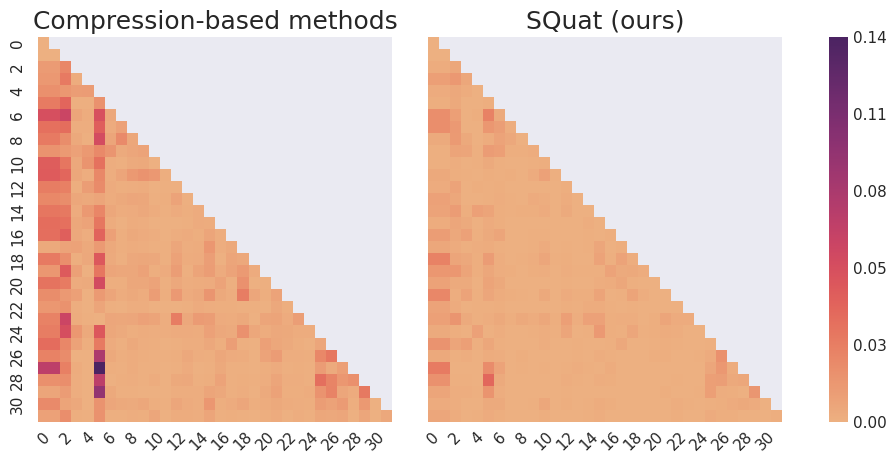

In [12]:
attention_gap_heatmap(score_diff_v_1, score_diff_v_2, mask, 'attention_gap_heatmap.png')